# SMAI Assignment - 2

## Question 1: Naive Bayes and Clustering

### Part 1: Naive Bayes

[Files](https://drive.google.com/drive/folders/1OUVrOMp2jSSBDJSqvEyXDFTrhiyZnqit?usp=sharing)

You will be performing Sentiment Analysis on a product review dataset with reviews from customers and star rating belonging to four classes (1,2,4,5). You can use sklearn for this question. Your tasks are as follows:

1.   Clean the text by removing punctations and preprocess them using techniques such as stop word removal, stemming etc. You can explore anything!
1.  Create BoW features using the word counts. You can choose the words that form the features such that the performance is optimised. Use the train-test split provided in `train_test_index.pickle` and report any interesting observations based on metrics such as accurarcy, precision, recall and f1 score (You can use Classification report in sklearn).
1. Repeat Task 2 with TfIdf features.

In [46]:
import pickle
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
with open('train_test_index.pickle', 'rb') as handle:
    train_test_index_dict = pickle.load(handle)

In [48]:
train_test_index_dict.keys()

dict_keys(['train_index', 'test_index'])

In [49]:
data = pd.read_csv('product_reviews.csv')
data.head()
data.shape

(26661, 3)

#### Data Preprocessing - Text Cleaning

In [50]:
import string


# Functions to preprocess the text for better feature extraction.

def remove_punctuations(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def convert_to_lowercase(text):
    return text.lower()

def remove_stop_words(text):
    stop_words = set([
        "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves",
        "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
        "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was",
        "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and",
        "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between",
        "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off",
        "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both",
        "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too",
        "very", "s", "t", "can", "will", "just", "don", "should", "now"
    ])
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def stem_text(text):
    # Simple stemming (removing 'ing' and 's' suffixes)
    stemmed_words = [word[:-3] if word.endswith('ing') else word[:-1] if word.endswith('s') else word for word in text.split()]
    return ' '.join(stemmed_words)


In [51]:
data['text'] = data['text'].apply(remove_punctuations)
data['text'] = data['text'].apply(convert_to_lowercase)
data['text'] = data['text'].apply(remove_stop_words)
data['text'] = data['text'].apply(stem_text)

#### BoW features

In [52]:
X_train, X_test = data.iloc[train_test_index_dict['train_index']]['text'], data.iloc[train_test_index_dict['test_index']]['text']
y_train, y_test = data.iloc[train_test_index_dict['train_index']]['stars'], data.iloc[train_test_index_dict['test_index']]['stars']

In [53]:
X_train.shape,y_train.shape

((17862,), (17862,))

**Bag of Words**

In [54]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

**Naive Bayes Algorithm from Scratch**

In [55]:
import numpy as np

class NaiveBayes:
    def __init__(self):
        self.prior = None
        self.conditional_probs = None
        self.classes = None

    def fit(self, X_train, y_train):
        self.classes = np.unique(y_train)
        num_classes = len(self.classes)
        num_features = X_train.shape[1]

        # Initialize dictionaries to store prior and conditional probabilities
        self.prior = {c: 0 for c in self.classes}
        self.conditional_probs = {c: np.ones(num_features) for c in self.classes}

        # Prior probabilities
        total_samples = len(y_train)
        for c in self.classes:
            num_samples_in_class = np.sum(y_train == c)
            self.prior[c] = num_samples_in_class / total_samples

        # Calculate conditional probabilities
        for c in self.classes:
            X_c = X_train[y_train == c]
            total_word_counts = np.sum(X_c, axis=0)
            total_word_counts_class = np.sum(total_word_counts)
            self.conditional_probs[c] = (total_word_counts + 1) / (total_word_counts_class + num_features)

    def predict(self, X_test):
        predictions = []
        for x in X_test:
            posteriors = []
            for c in self.classes:
                # Calculate the log of the posterior probability
                posterior = np.log(self.prior[c]) + np.sum(np.log(self.conditional_probs[c]) * x)
                posteriors.append(posterior)
            # prediction contains the class with the highest probability
            prediction = self.classes[np.argmax(posteriors)]
            predictions.append(prediction)
        return np.array(predictions)


In [56]:
nb_classifier = NaiveBayes()

# Train the classifier
nb_classifier.fit(X_train_bow.toarray(), y_train)
y_pred_nb = nb_classifier.predict(X_test_bow.toarray())


# ---------------- Classification Report --------------------

print(classification_report(y_test, y_pred_nb))


              precision    recall  f1-score   support

         1.0       0.74      0.76      0.75      1149
         2.0       0.40      0.06      0.10       587
         4.0       0.48      0.48      0.48      1981
         5.0       0.78      0.85      0.82      5082

    accuracy                           0.70      8799
   macro avg       0.60      0.54      0.54      8799
weighted avg       0.68      0.70      0.68      8799



#### TFIDF 

In [57]:
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the data
X_tfidf_train = tfidf_vectorizer.fit_transform(X_train)
X_tfidf_test = tfidf_vectorizer.transform(X_test)


In [58]:
X_tfidf_train.shape,y_train.shape

((17862, 23232), (17862,))

In [59]:
nb_classifier2 = NaiveBayes()
nb_classifier2.fit(X_tfidf_train.toarray(), y_train)
y_pred_tfidf_nb = nb_classifier2.predict(X_tfidf_test.toarray())

# --------------- Classification Report ----------------
print(classification_report(y_test, y_pred_tfidf_nb))

              precision    recall  f1-score   support

         1.0       0.94      0.10      0.19      1149
         2.0       0.00      0.00      0.00       587
         4.0       0.48      0.01      0.02      1981
         5.0       0.59      1.00      0.74      5082

    accuracy                           0.59      8799
   macro avg       0.50      0.28      0.24      8799
weighted avg       0.57      0.59      0.46      8799



/Users/souvikg544/miniconda3/envs/classicml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/souvikg544/miniconda3/envs/classicml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/souvikg544/miniconda3/envs/classicml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

### Part 2: Clustering

You will be performing kmeans clustering on the same product reviews dataset from Part 1. In this question, instead of statistically computing features, you will use the embeddings obtained from a neural sentiment analysis model (huggingface: siebert/sentiment-roberta-large-english).

You can use sklearn for this question. Your tasks are as follows:


1. Perform kmeans clustering using sklearn. Try various values for number of clusters (k) and plot the elbow curve. For each value of k, plot WCSS (Within-Cluster Sum of Square). WCSS is the sum of the squared distance between each point and the centroid in a cluster.
1. Perform task 1 with cluster initialisation methods [k-means++, forgy ("random" in sklearn)].
1. In this case, since the ground truth labels (star rating) are available we can evaluate the clustering using metrics like purity, nmi and rand score. Implement these metrics from scratch and evaluate the clustering. [Reference](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html)

In [60]:
import gzip
import numpy as np

f = gzip.GzipFile('roberta_embeds.npy.gz', "r")
embeds = np.load(f)
print(embeds.shape)

(26661, 1024)


In [97]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

# Function to plot the elbow curve
def plot_elbow_curve(data, max_clusters,init):
    wcss = []  # Within-Cluster Sum of Square

    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init=init, random_state=42,n_init='auto')
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters + 1), wcss, marker='o')
    plt.title(f'Elbow Curve for K means initialization = {init}')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('WCSS')
    plt.show()

# Function to perform KMeans clustering with different initialization methods
def perform_kmeans(data, k, initialization):
    kmeans = KMeans(n_clusters=k, init=initialization, random_state=42)
    kmeans.fit(data)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    return centroids, labels, kmeans

# Function to calculate purity
def purity_score(y_true, y_pred):
    contingency_matrix = np.zeros((len(np.unique(y_pred)), len(np.unique(y_pred))))
    #print(contingency_matrix.shape)
    for i, j in zip(y_true, y_pred):
        contingency_matrix[int(i-1),int(j-1)] +=1
    
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

# Function to calculate NMI
def calculate_nmi(y_true, y_pred):
    return normalized_mutual_info_score(y_true, y_pred)

# Function to calculate Rand Score
def calculate_rand_score(y_true, y_pred):
    return adjusted_rand_score(y_true, y_pred)


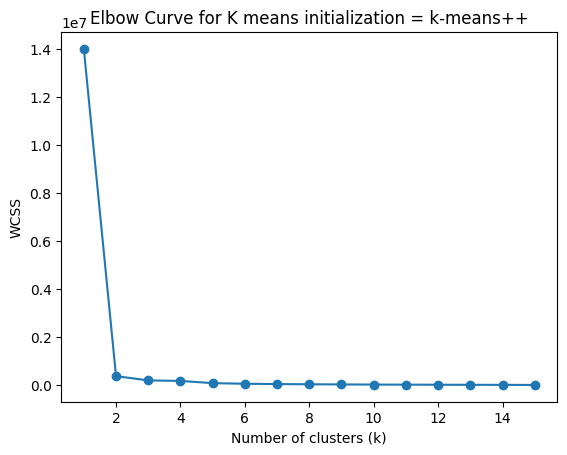

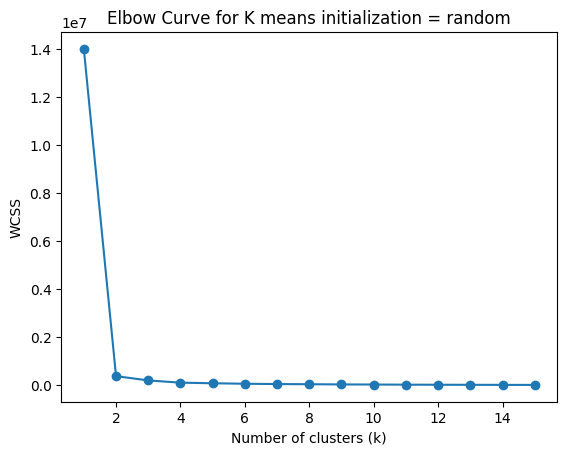

In [62]:
# Task 2: Perform KMeans clustering with different initialization methods
plot_elbow_curve(embeds, max_clusters=15, init= 'k-means++')

#centroids_forgy, labels_forgy, kmeans_foggy = perform_kmeans(embeds, k, 'random')
plot_elbow_curve(embeds, max_clusters=15, init = 'random')

In [94]:
k = 5  # Number of clusters
centroids_kmeanspp, labels_kmeans_pp, kmeans_pp = perform_kmeans(embeds, k, 'k-means++')

/Users/souvikg544/miniconda3/envs/classicml/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [98]:
ground_truth_labels = data['stars'].to_numpy().astype(int)


purity_kmeans_pp = purity_score(ground_truth_labels, labels_kmeans_pp)
nmi_kmeans_pp = calculate_nmi(ground_truth_labels, labels_kmeans_pp)
rand = calculate_rand_score(ground_truth_labels, labels_kmeans_pp)
print(f"Purity = {purity_kmeans_pp} NMI = {nmi_kmeans_pp} Rand Score = {rand}")

Purity = 0.711113611642474 NMI = 0.4609757420802488 Rand Score = 0.4549202171023023
